# GPU Bootstrap Particle Filter — True vs BPF Performance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (16, 5)
plt.rcParams['figure.dpi'] = 120

CSV_PATH = 'bpf_output.csv'
df = pd.read_csv(CSV_PATH)
print(f'Loaded {len(df)} rows, scenarios: {df.scenario_name.unique()}')
df.head()

Loaded 40000 rows, scenarios: ['Baseline (G/t5)' 'Student-t (t5/t5)' 'High Persist' 'High Vol-of-Vol'
 'Low Vol' 'High Vol' 'Fast Revert' 'Pure Gaussian']


tick  scenario_id    scenario_name    true_h  true_vol    return     bpf_h  \
0     0            1  Baseline (G/t5) -3.869162  0.144485  0.306918 -4.084718   
1     1            1  Baseline (G/t5) -3.791914  0.150175  0.063189 -4.198663   
2     2            1  Baseline (G/t5) -3.870229  0.144408  0.014068 -4.355514   
3     3            1  Baseline (G/t5) -4.060481  0.131304 -0.019392 -4.504700   
4     4            1  Baseline (G/t5) -4.132217  0.126678  0.261221 -4.214431   

   bpf_loglik     apf_h  apf_loglik  imm_h  imm_best_model  imm_best_prob  \
0   -1.523358 -4.095369   -1.533840    0.0              -1            0.0   
1    0.935958 -4.208151   -0.000561    0.0              -1            0.0   
2    1.162566 -4.363255    0.002924    0.0              -1            0.0   
3    1.225698 -4.513140    0.002592    0.0              -1            0.0   
4   -1.060539 -4.223971    0.003022    0.0              -1            0.0   

     ewma_h   garch_h  
0 -4.056184 -3.814510  
1 -3.819991 -3.581981  
2 -3.870311 -3.657424  
3 -3.931581 -3.743302  
4 -3.992233 -3.826796

In [2]:
def plot_scenario(df, scenario_id=1, t_start=0, t_end=None):
    """True h vs BPF estimate — 2 panels: tracking + error."""
    d = df[df.scenario_id == scenario_id].copy()
    if t_end:
        d = d[(d.tick >= t_start) & (d.tick < t_end)]
    else:
        d = d[d.tick >= t_start]
    
    name = d.scenario_name.iloc[0]
    t = d.tick.values
    true_h = d.true_h.values
    bpf_h = d.bpf_h.values
    err = bpf_h - true_h
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8),
                                    sharex=True, height_ratios=[3, 1])
    
    # --- Panel 1: True vs BPF ---
    ax1.plot(t, true_h, 'w-', alpha=0.6, lw=0.8, label='True h(t)')
    ax1.plot(t, bpf_h, '#00bfff', lw=0.9, alpha=0.9, label='BPF')
    ax1.set_ylabel('Log-Volatility h(t)')
    ax1.set_title(f'{name}', fontsize=13)
    ax1.legend(loc='upper right', fontsize=9)
    ax1.grid(True, alpha=0.2)
    
    # --- Panel 2: Tracking error ---
    ax2.fill_between(t, err, 0, color='#00bfff', alpha=0.3)
    ax2.plot(t, err, '#00bfff', lw=0.5, alpha=0.7)
    ax2.axhline(0, color='w', lw=0.5, alpha=0.3)
    rmse = np.sqrt(np.mean(err[100:]**2)) if len(err) > 100 else np.sqrt(np.mean(err**2))
    ax2.set_ylabel('Error')
    ax2.set_xlabel('Tick')
    ax2.set_title(f'Tracking Error  (RMSE = {rmse:.4f})', fontsize=11)
    ax2.grid(True, alpha=0.2)
    
    plt.tight_layout()
    return fig

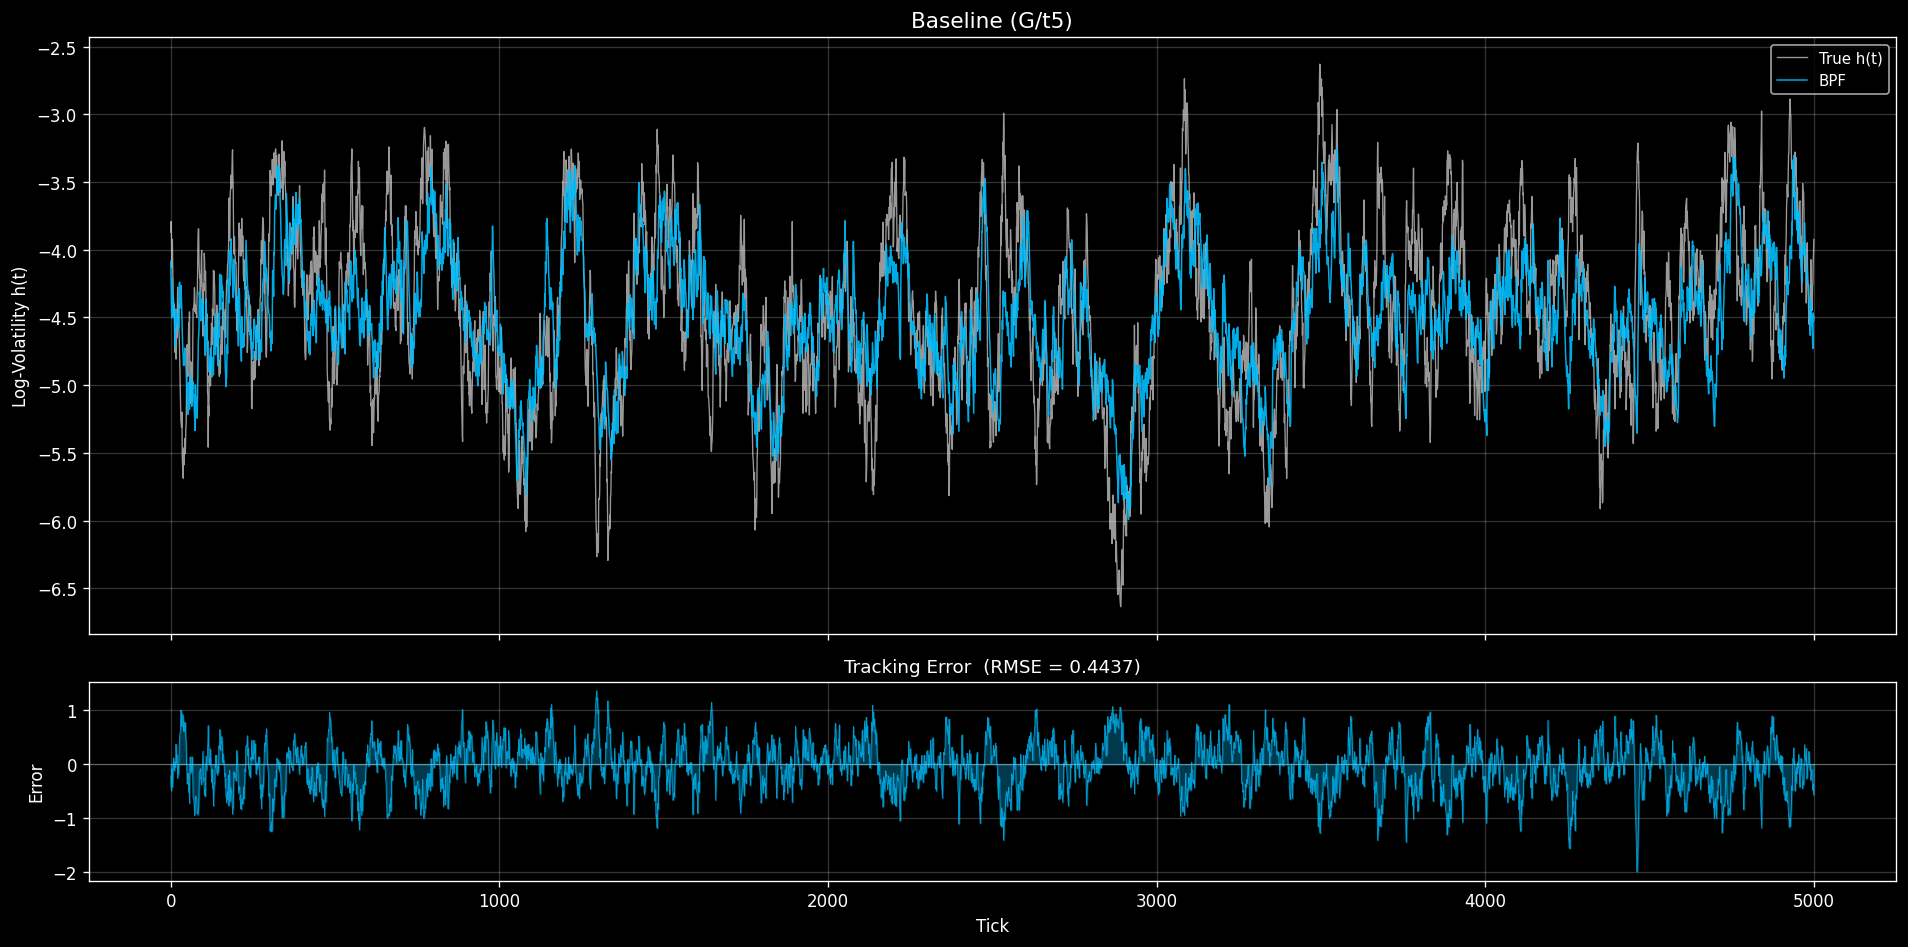

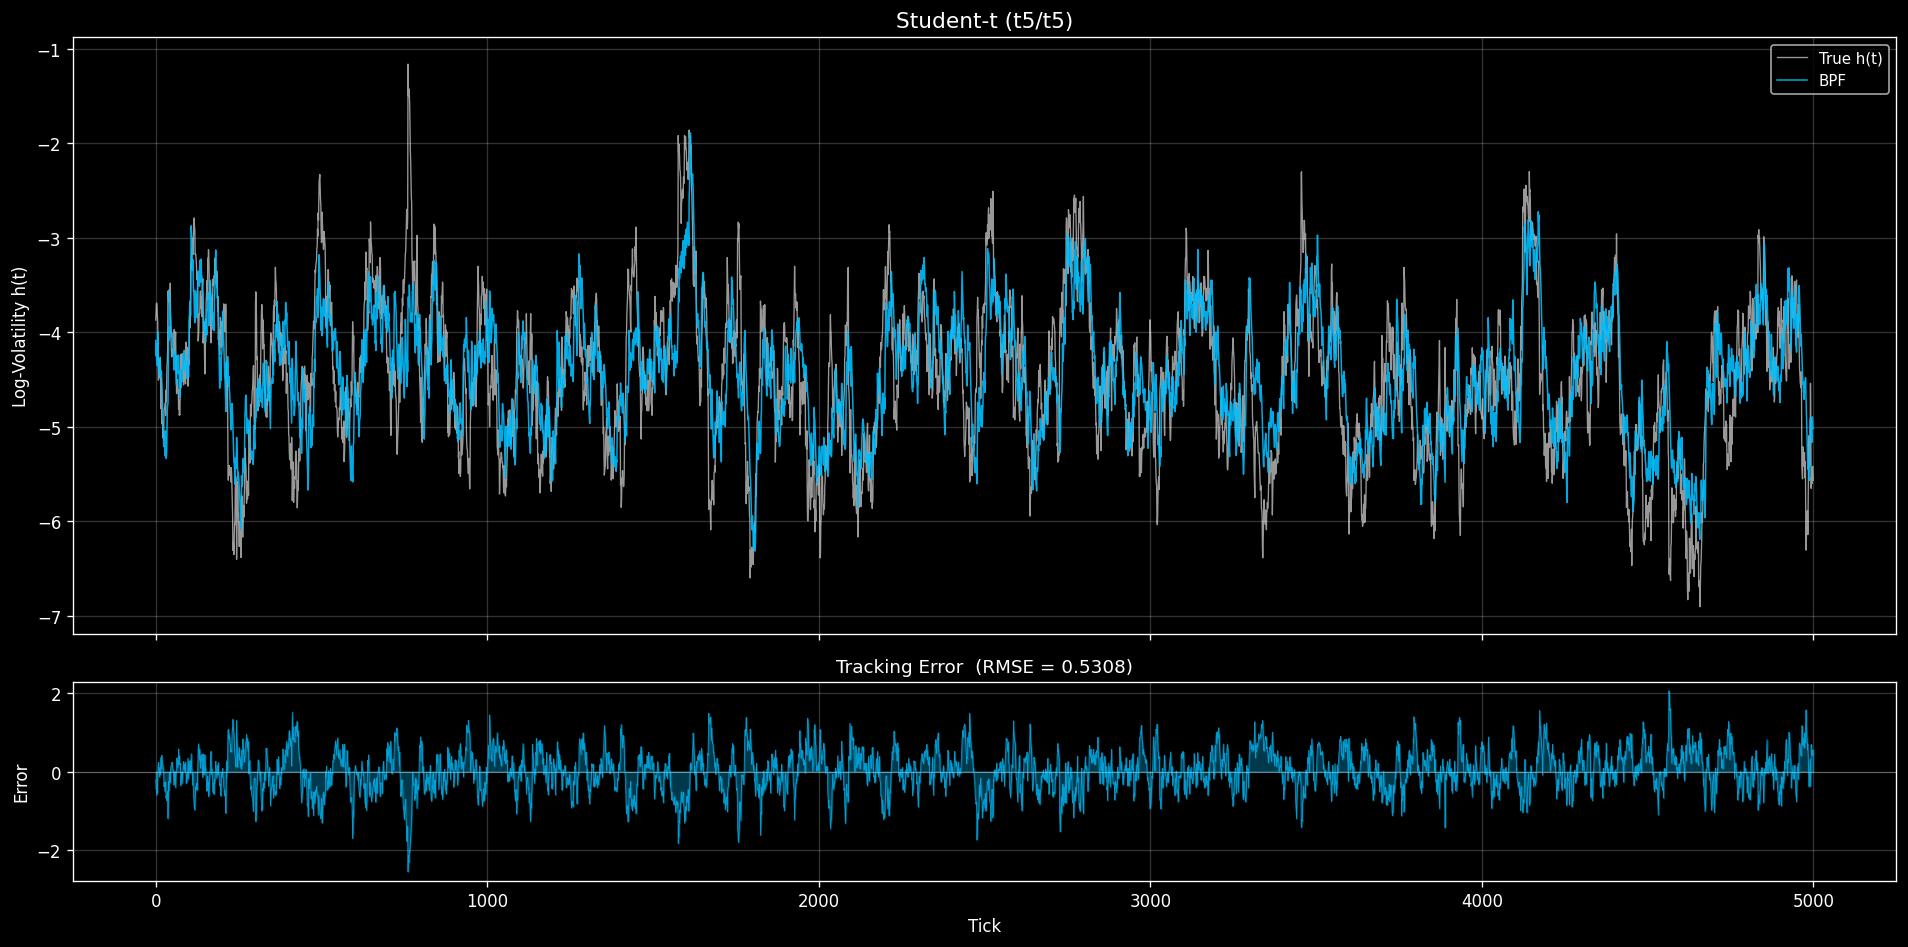

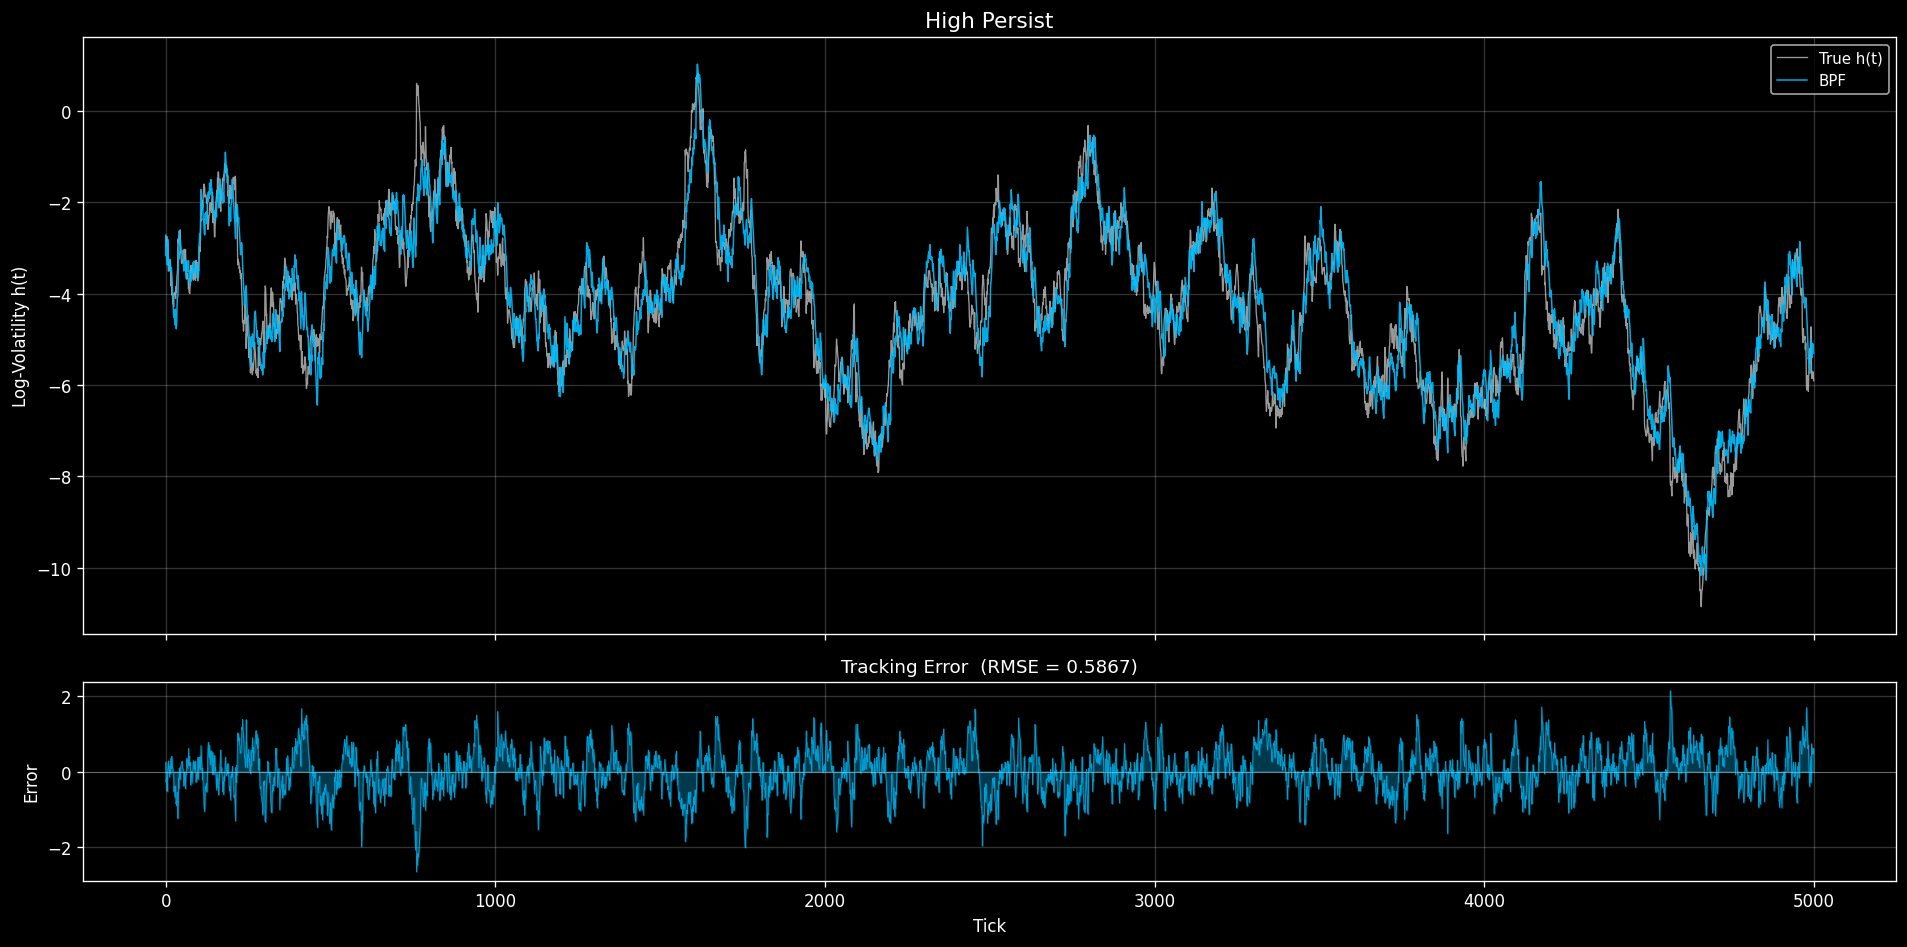

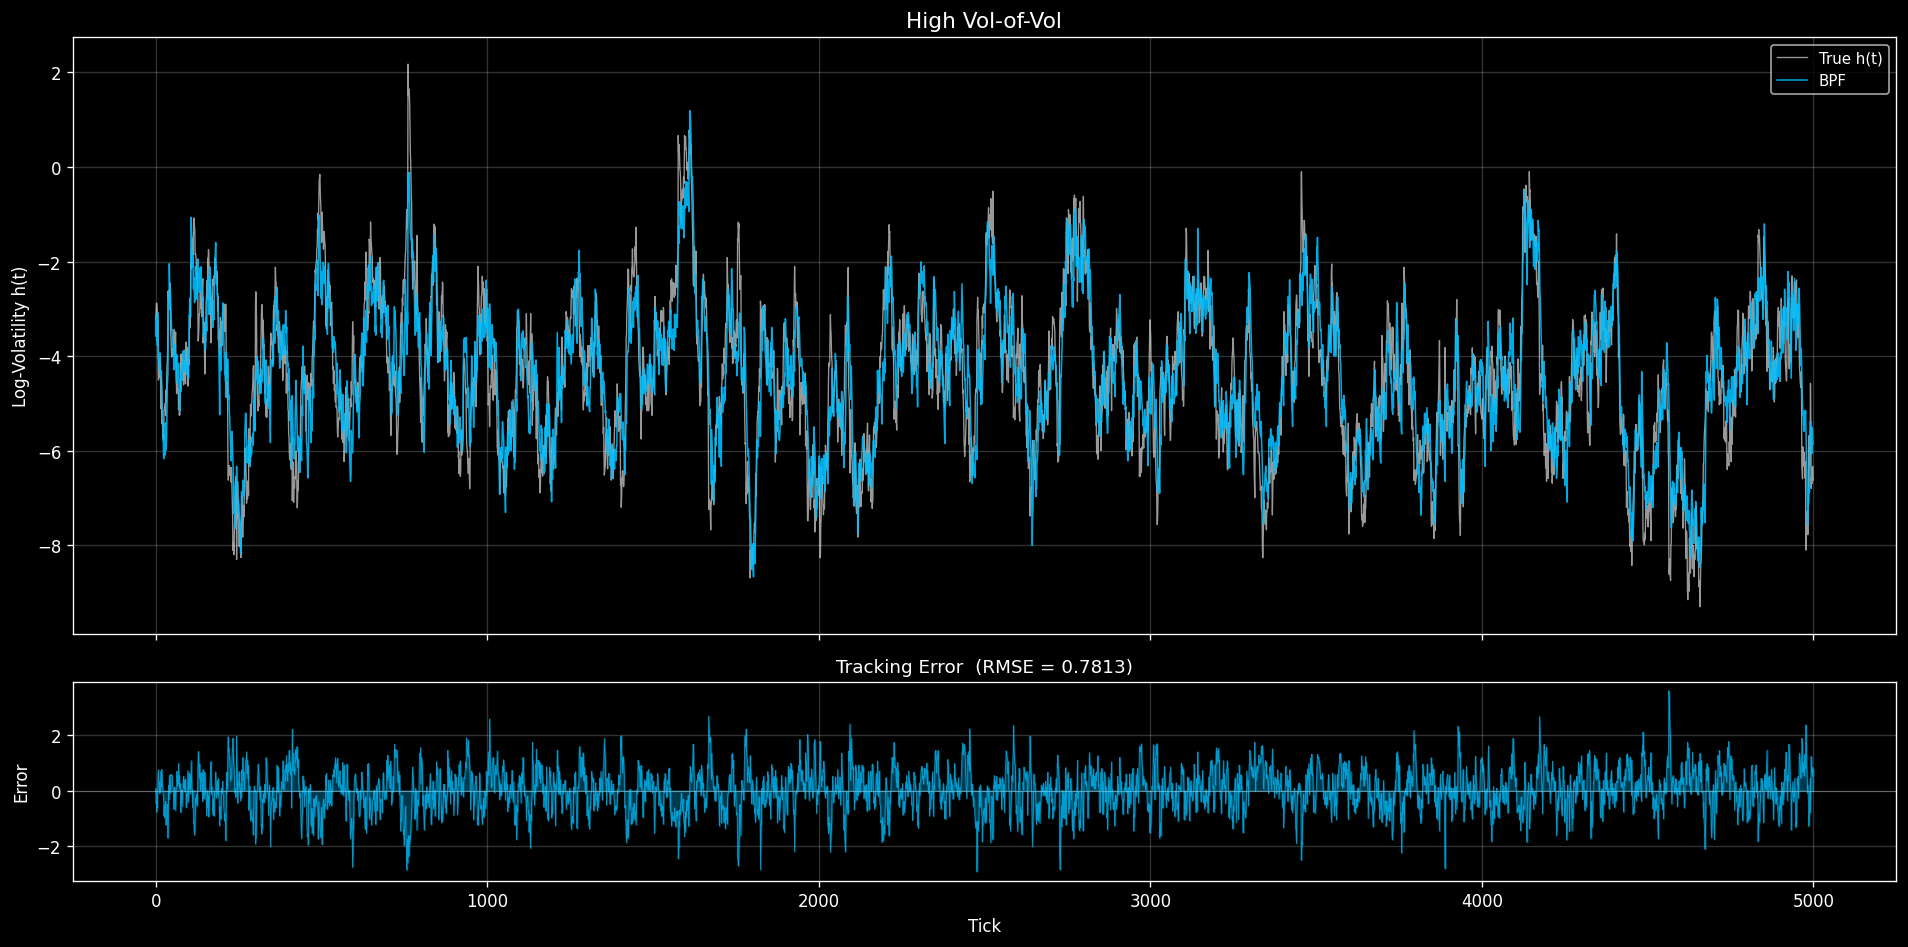

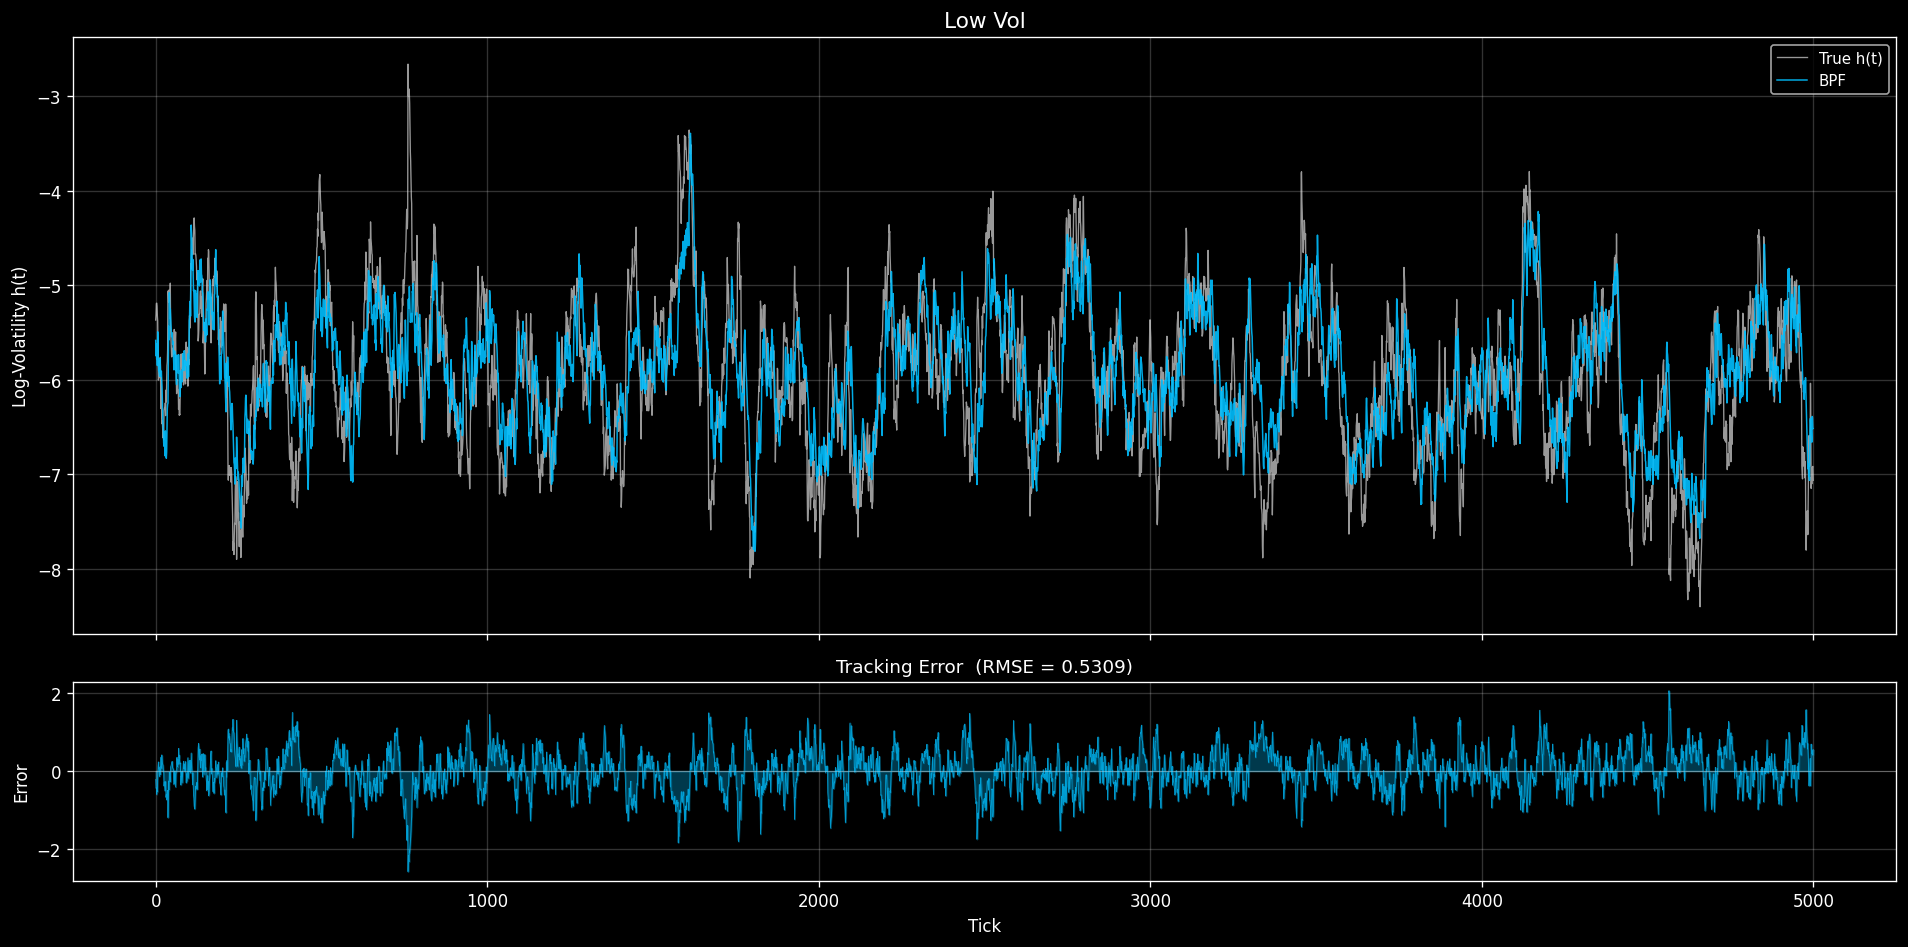

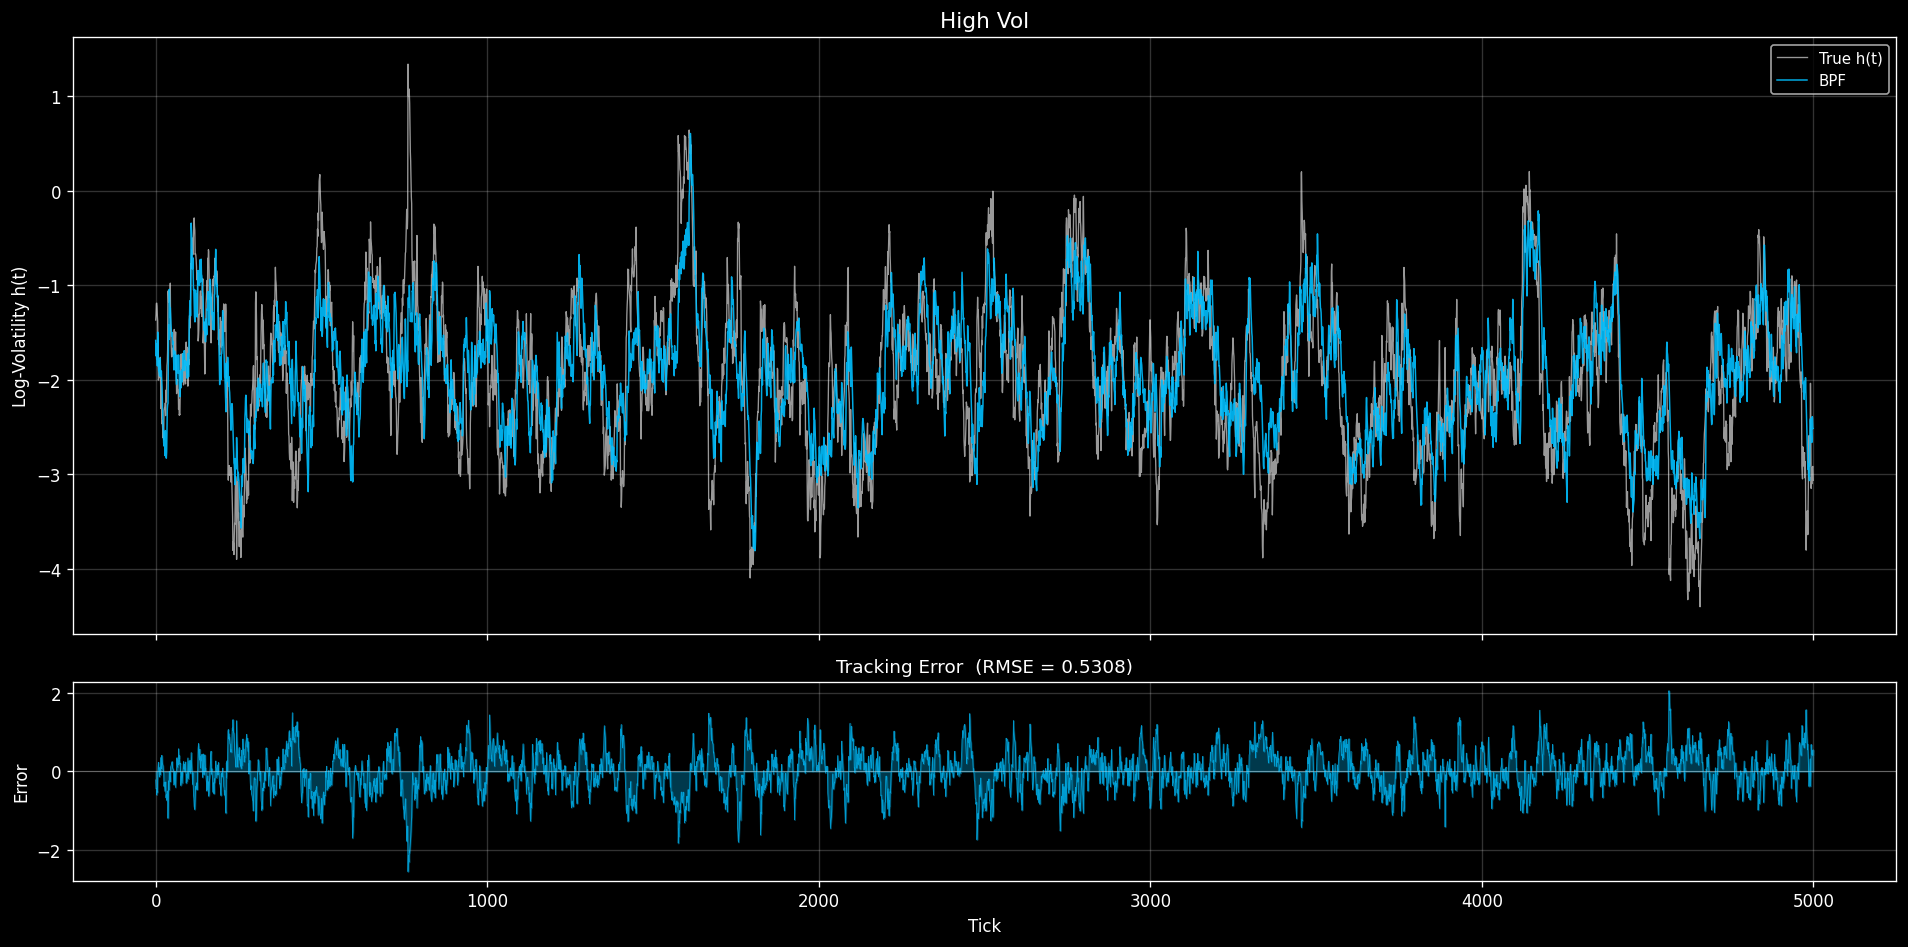

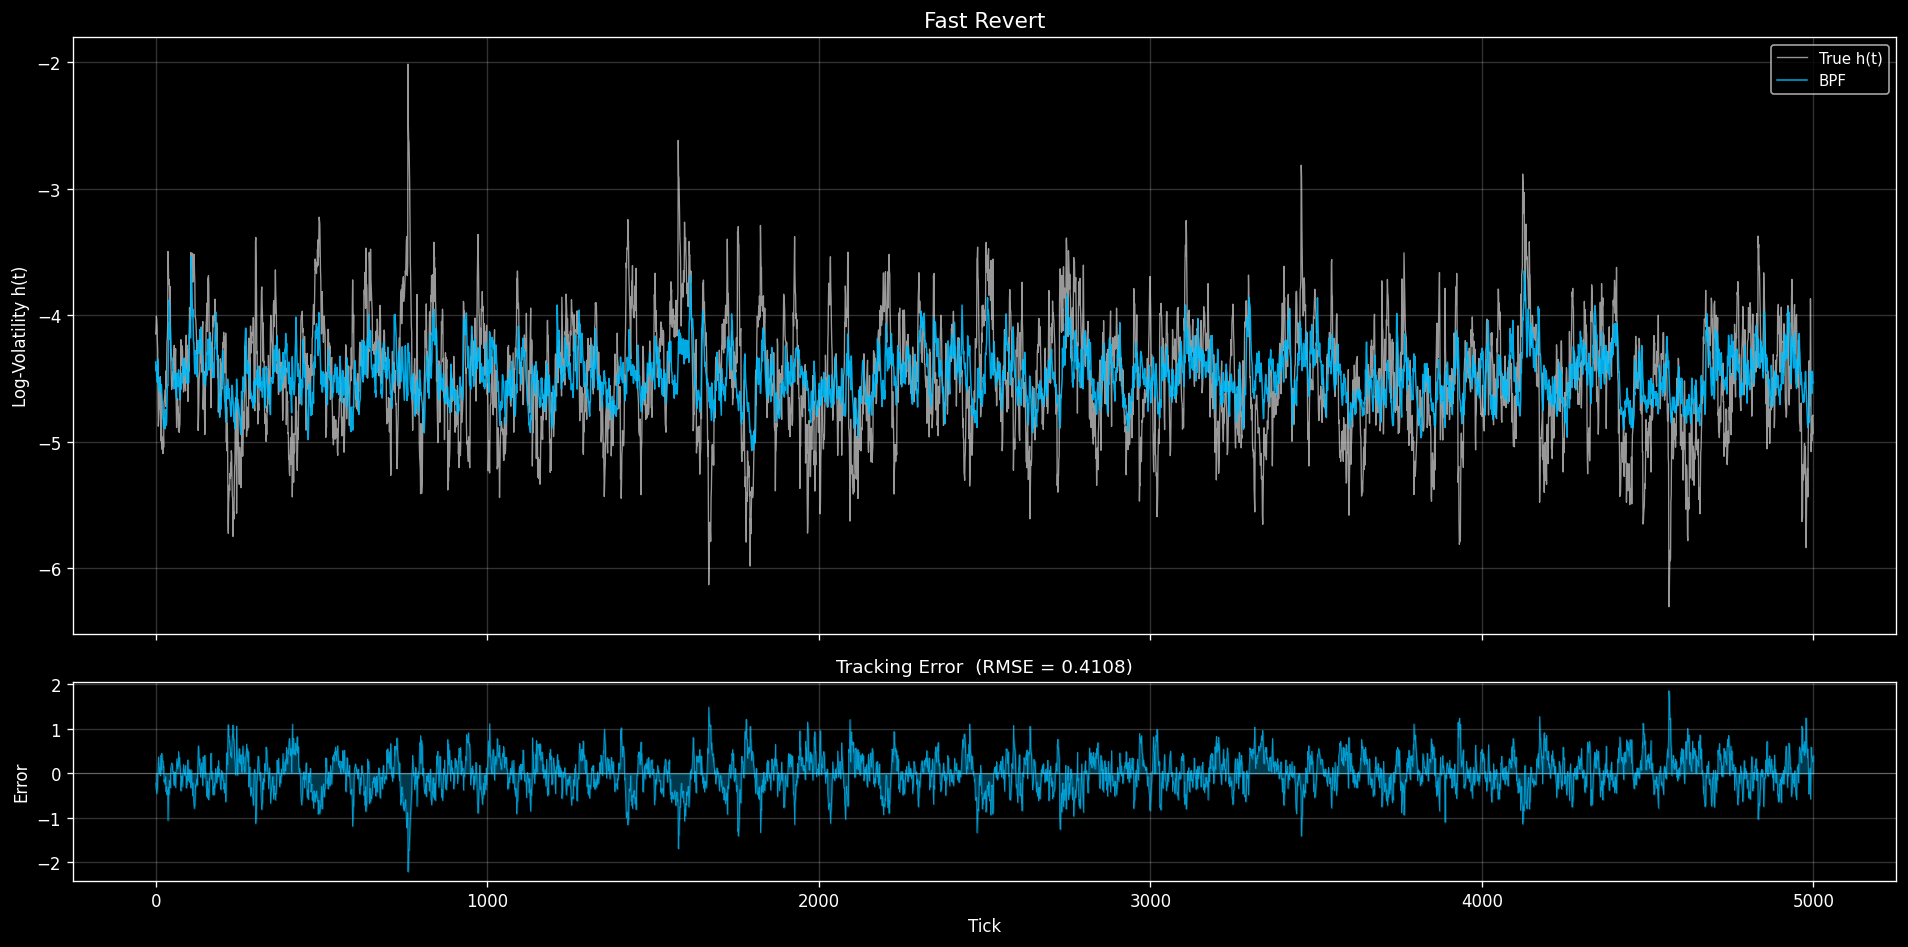

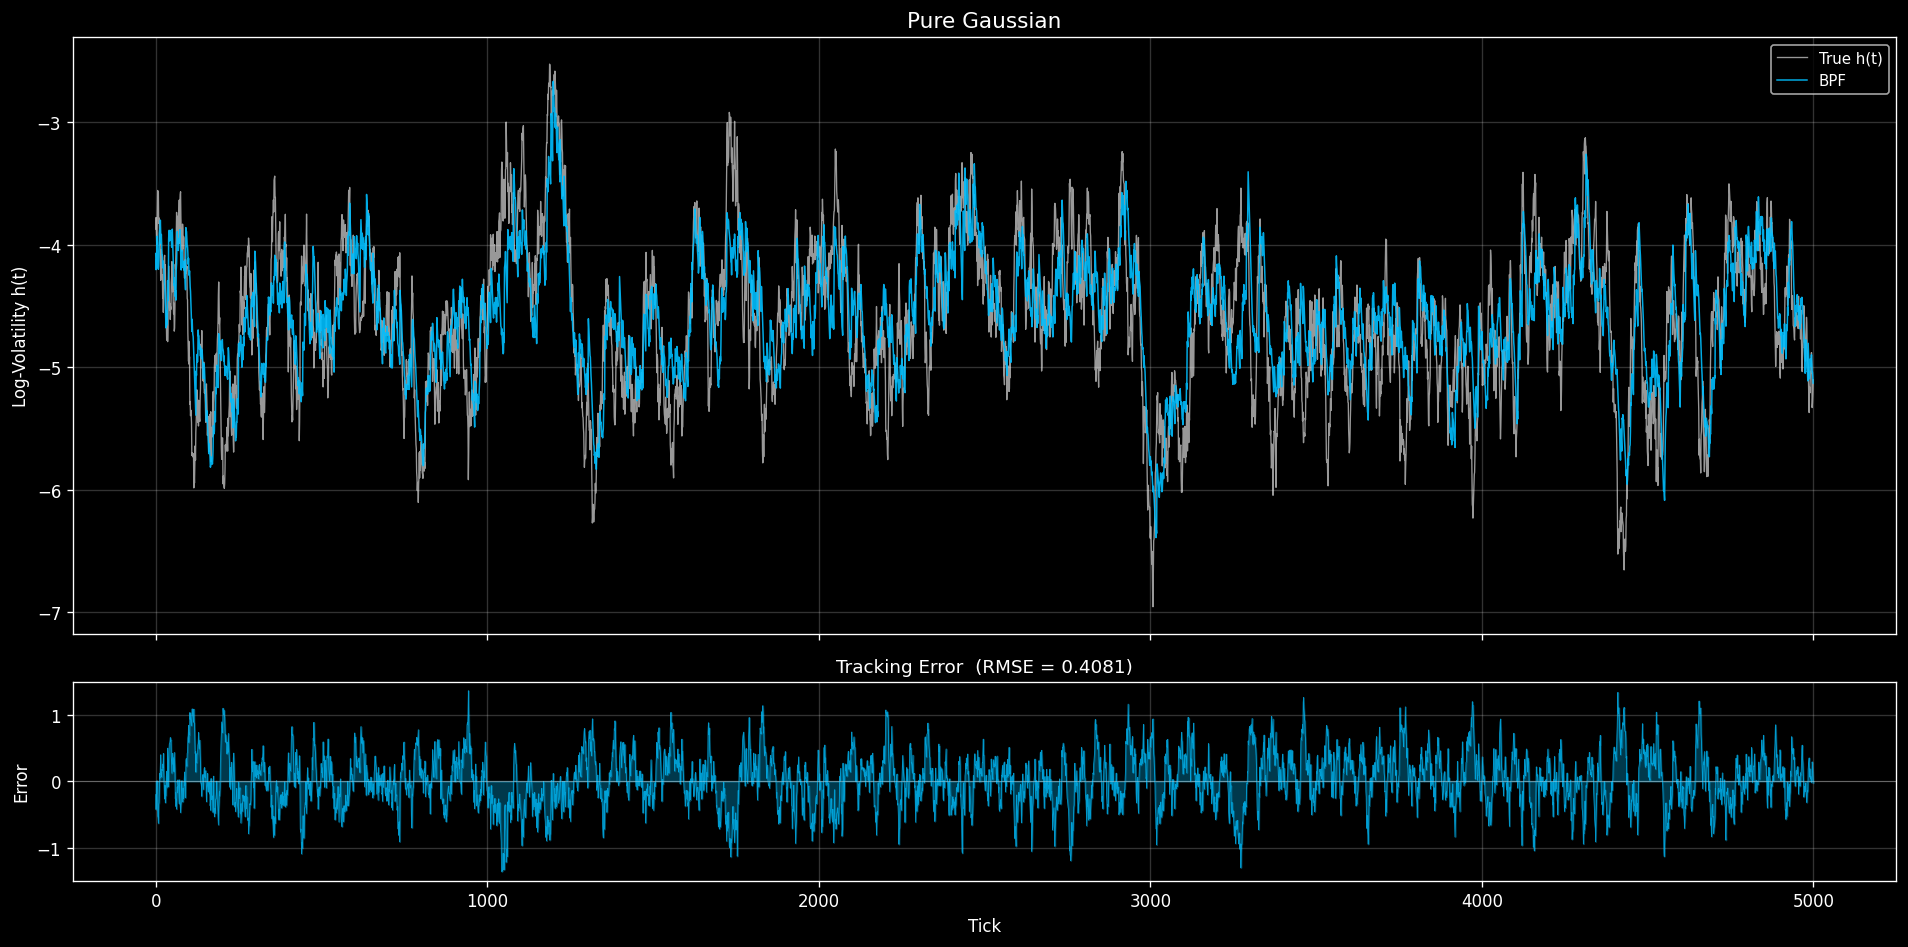

In [3]:
for sid in sorted(df.scenario_id.unique()):
    plot_scenario(df, scenario_id=sid)
    plt.show()

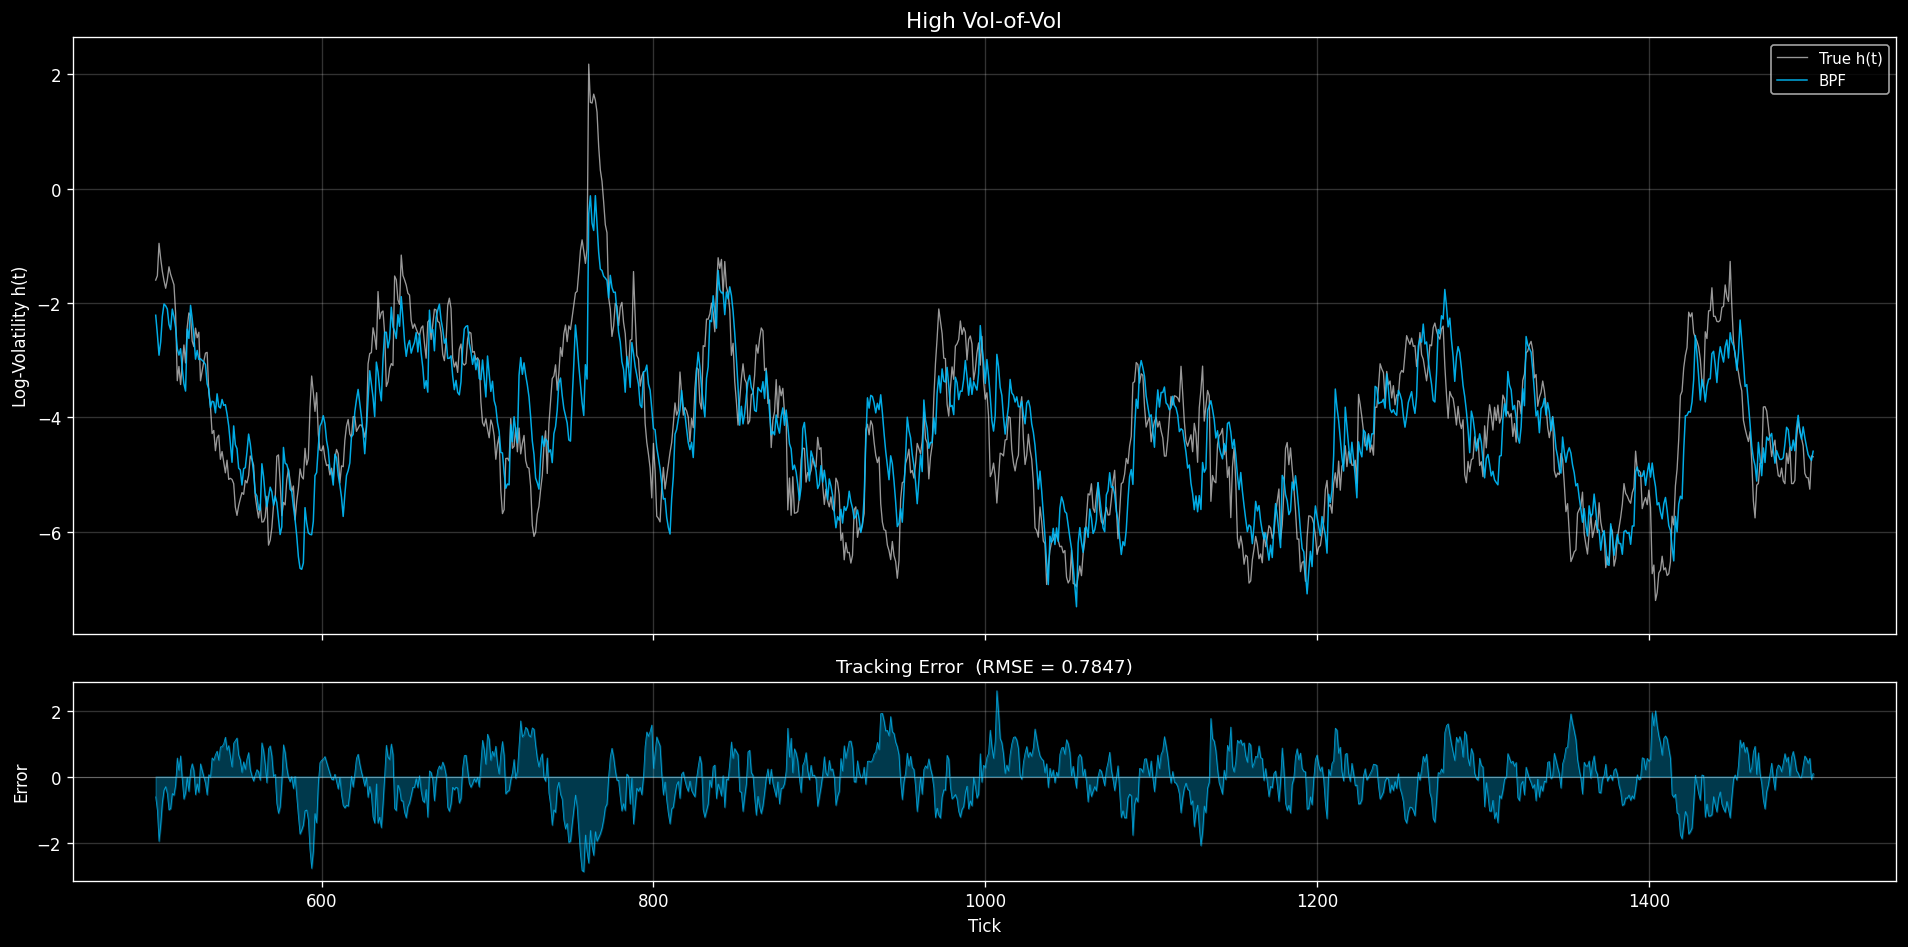

In [4]:
# Zoom into a volatile region
plot_scenario(df, scenario_id=4, t_start=500, t_end=1500)
plt.show()

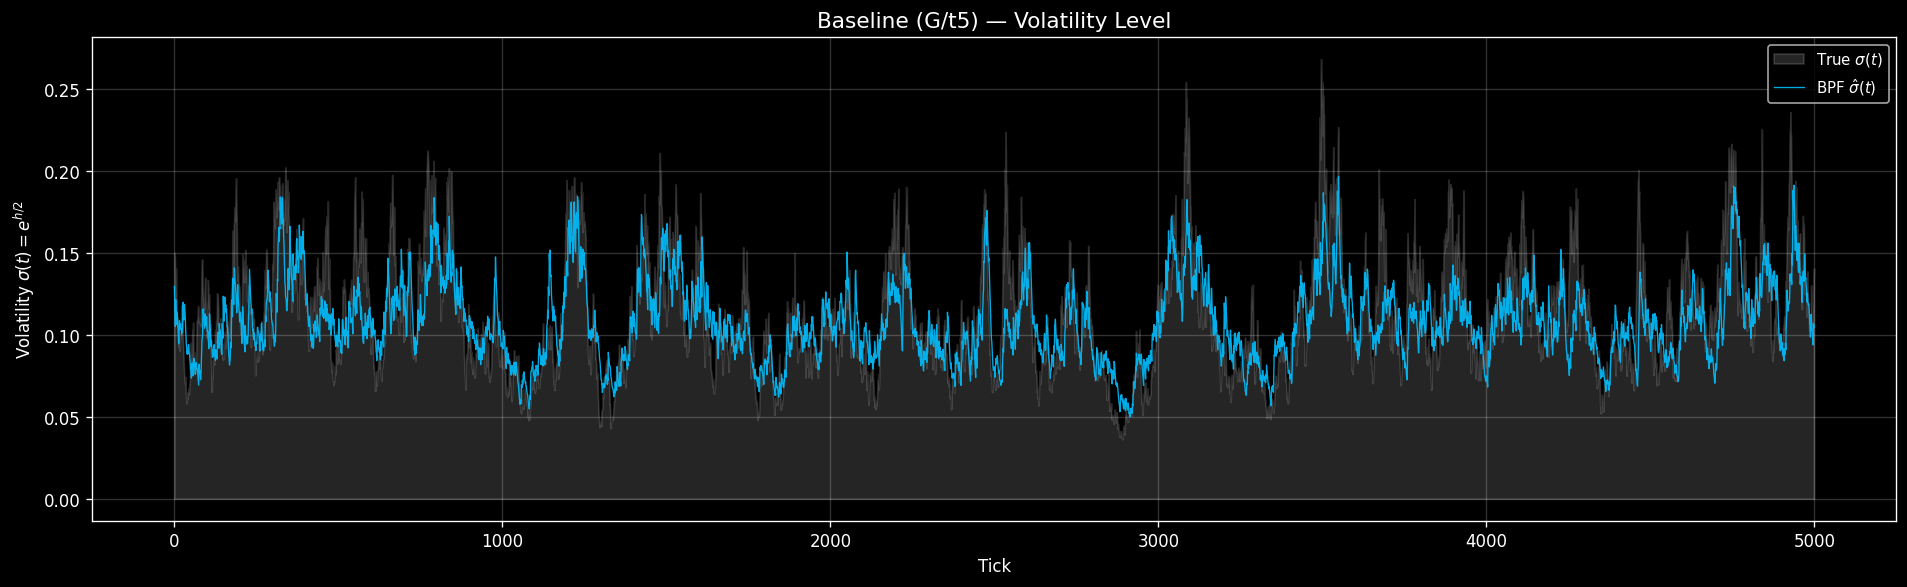

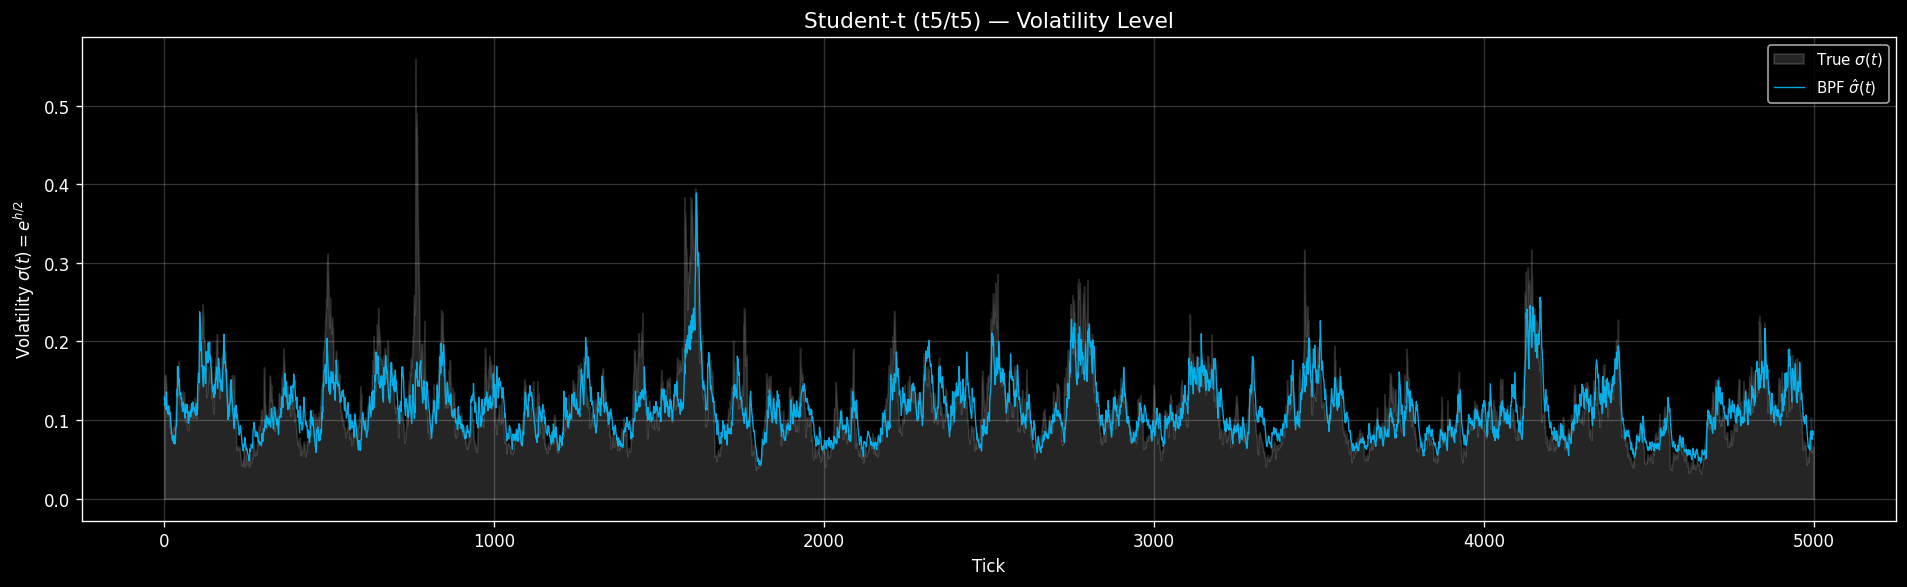

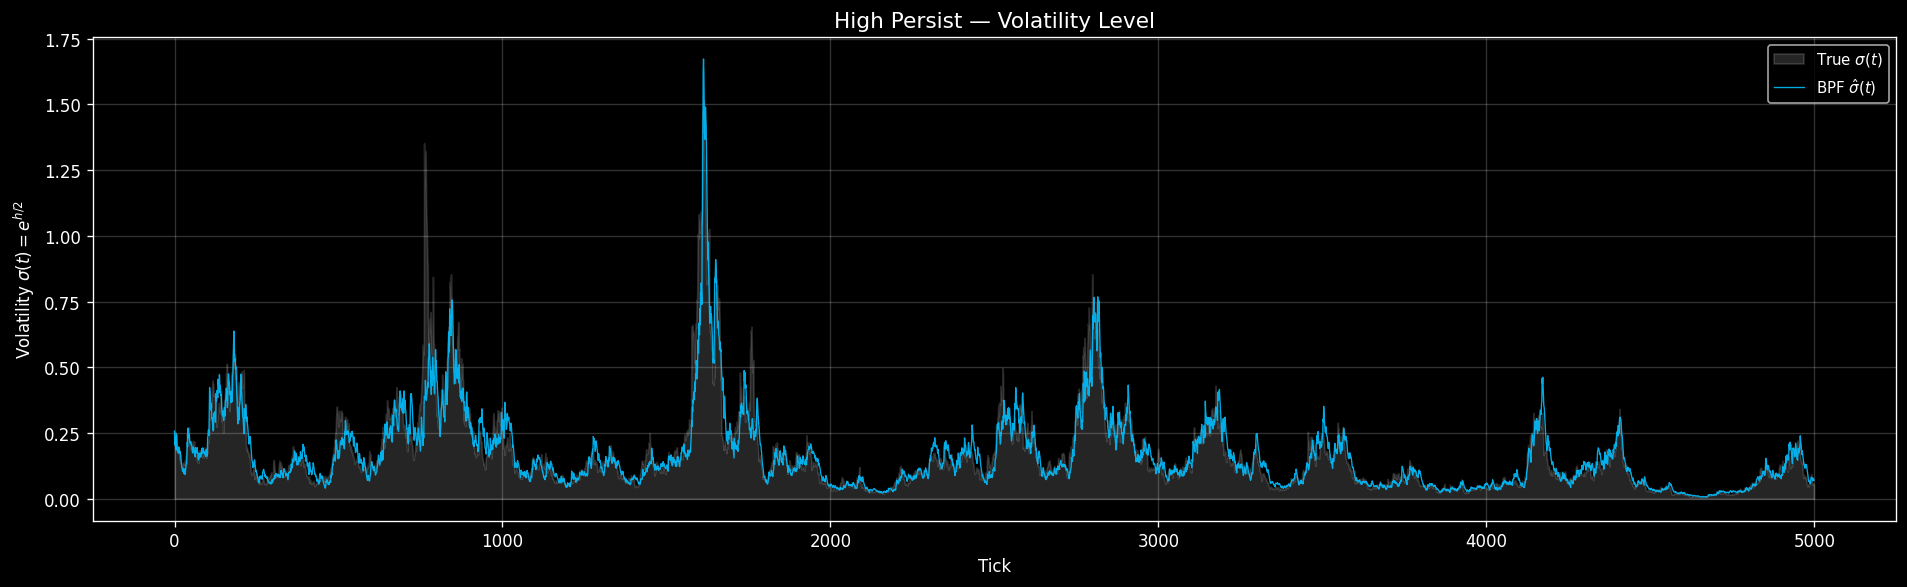

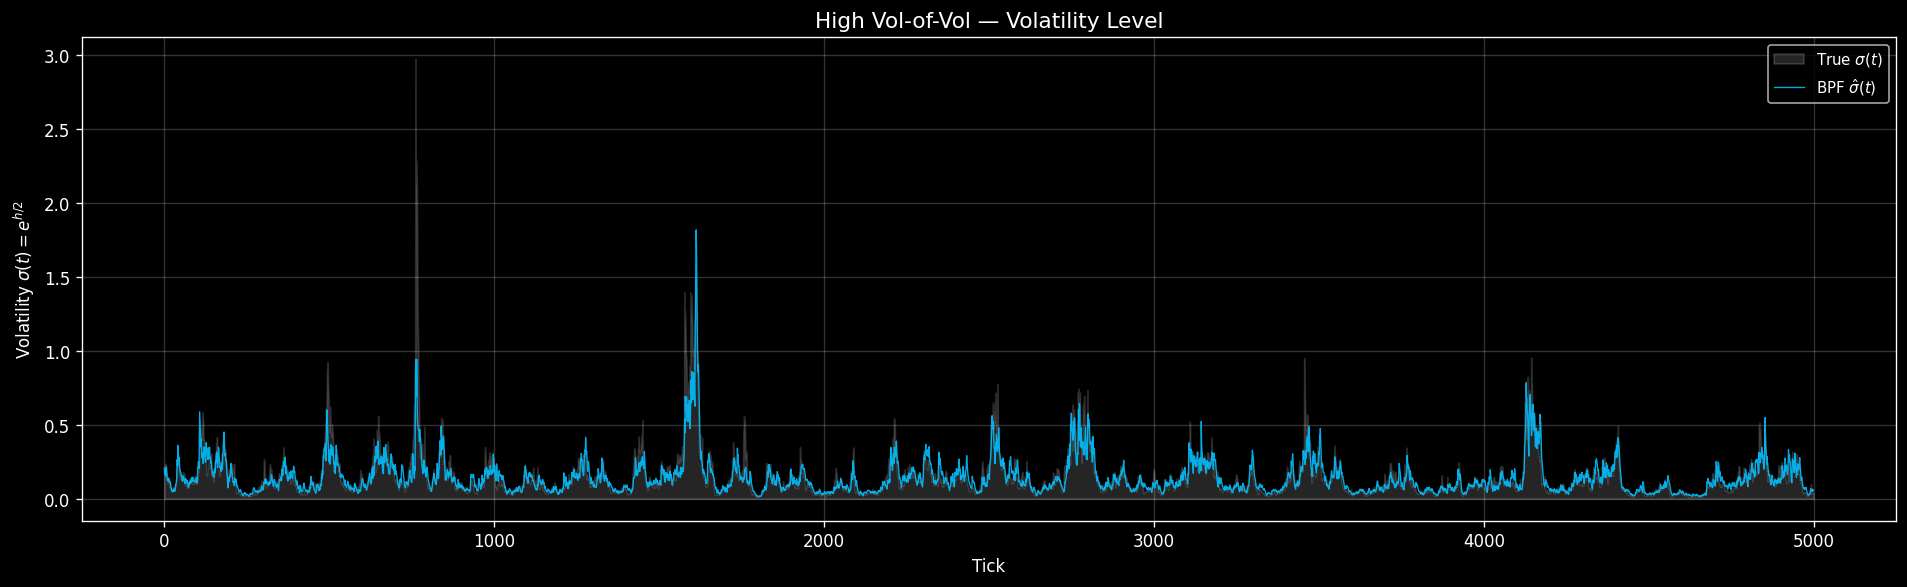

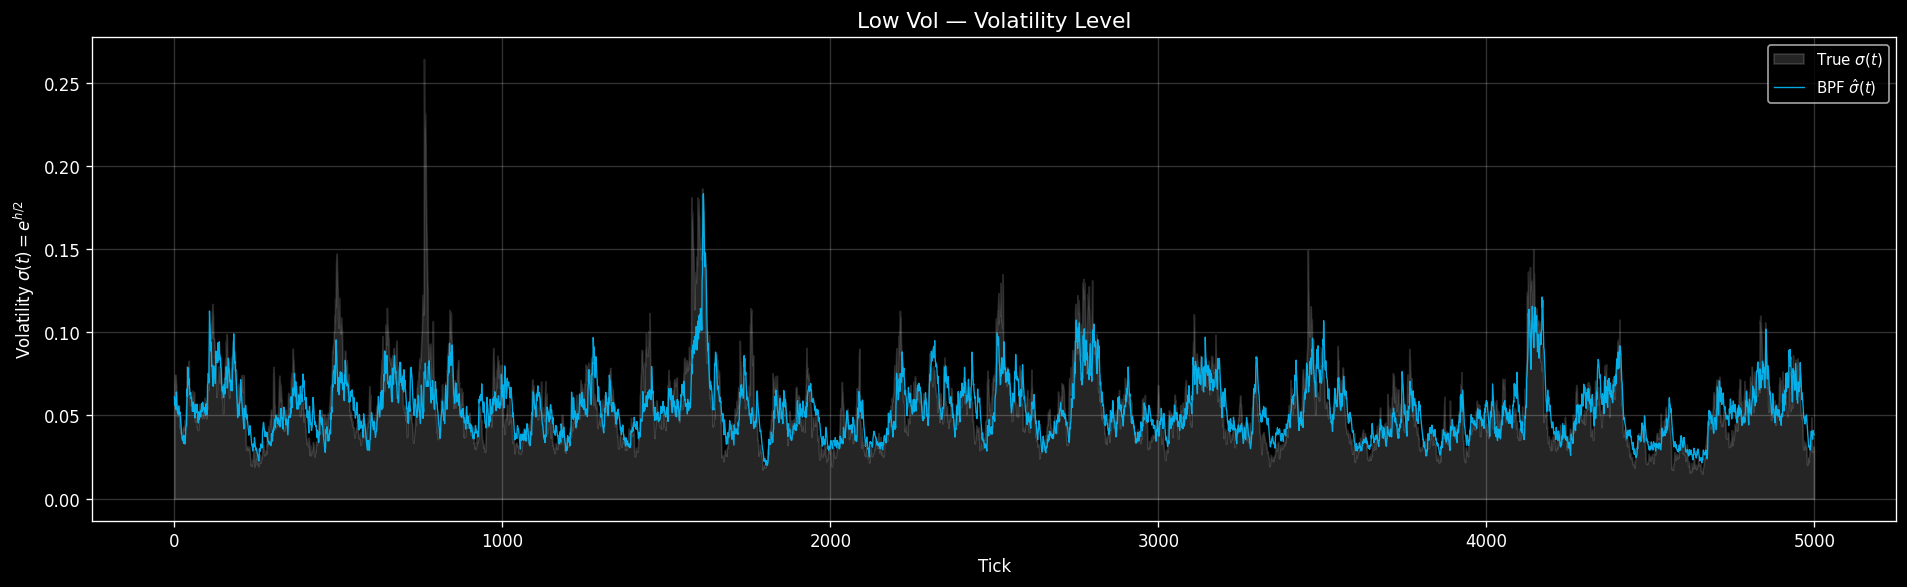

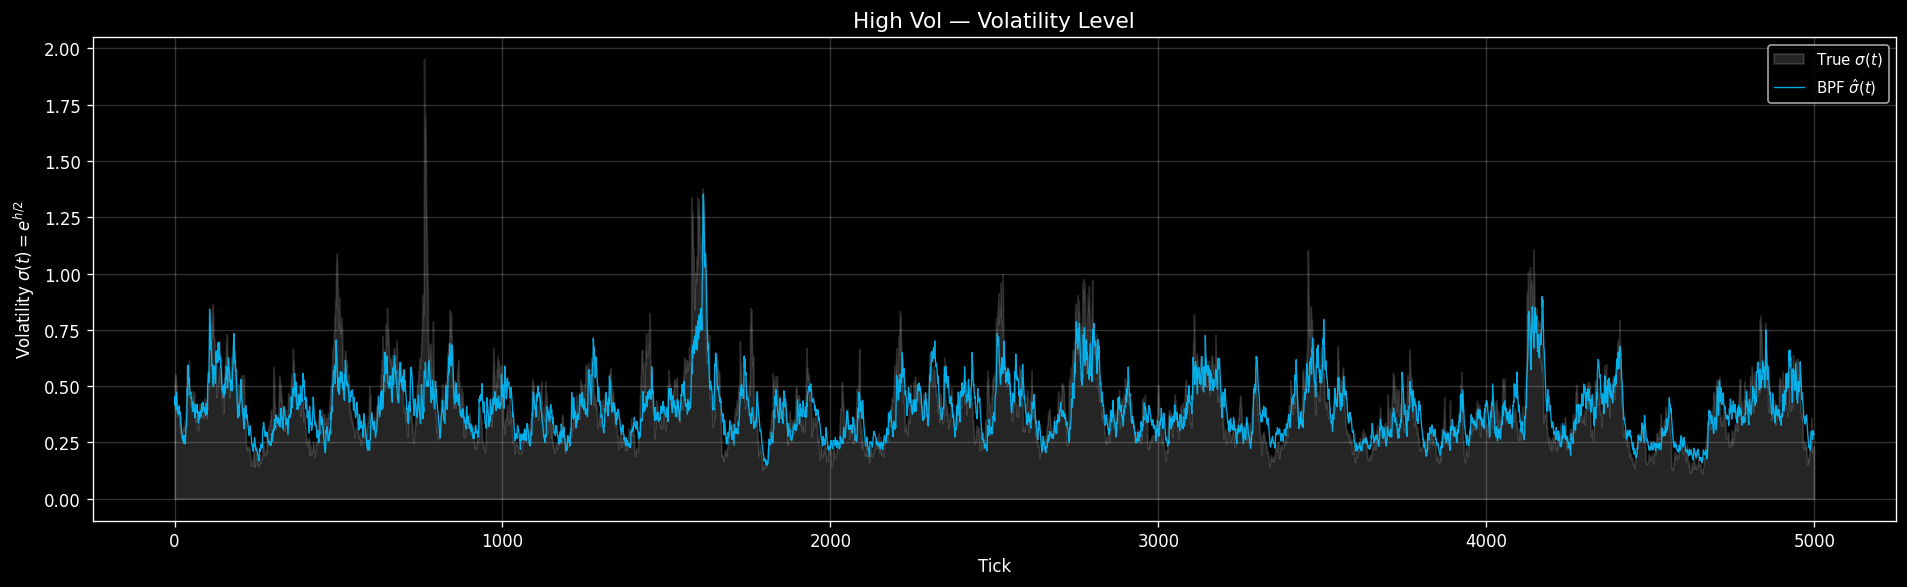

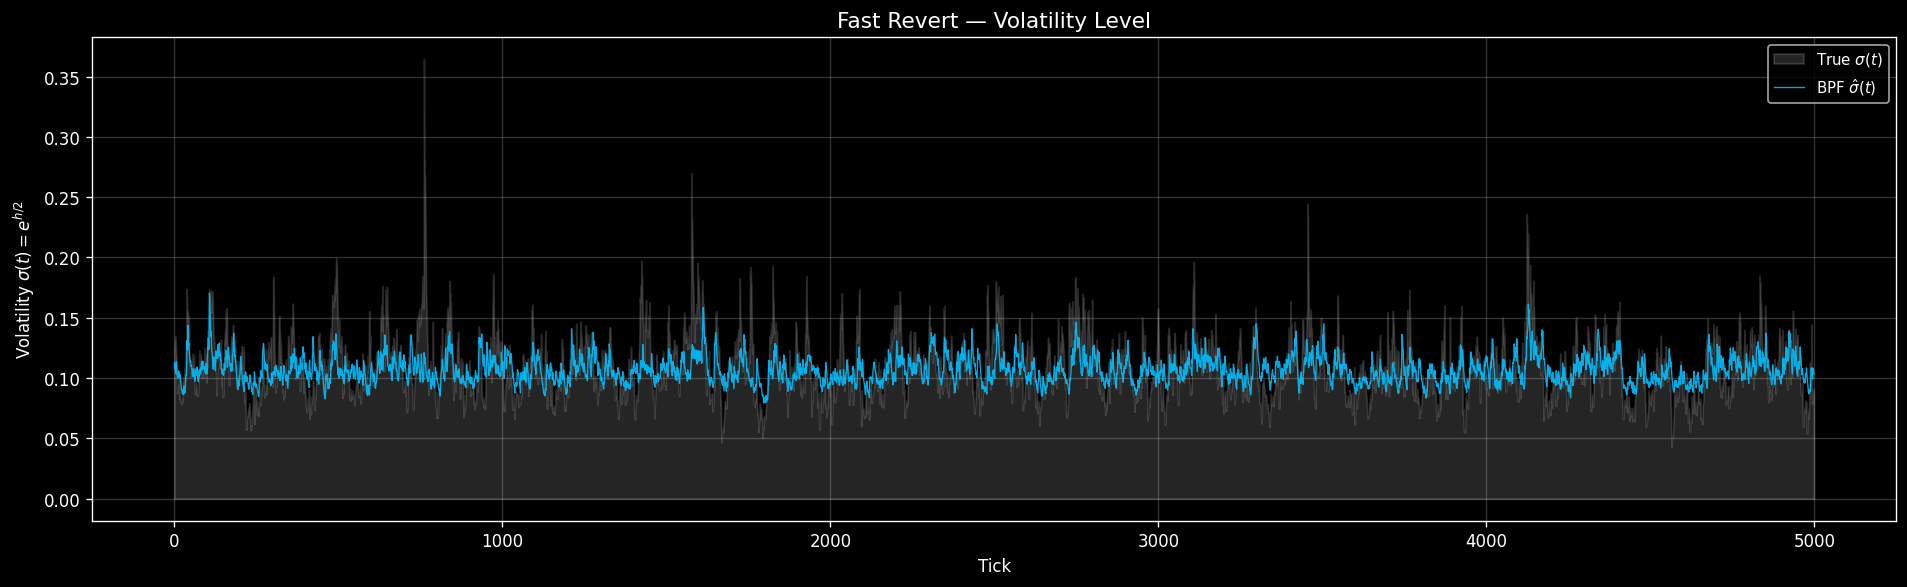

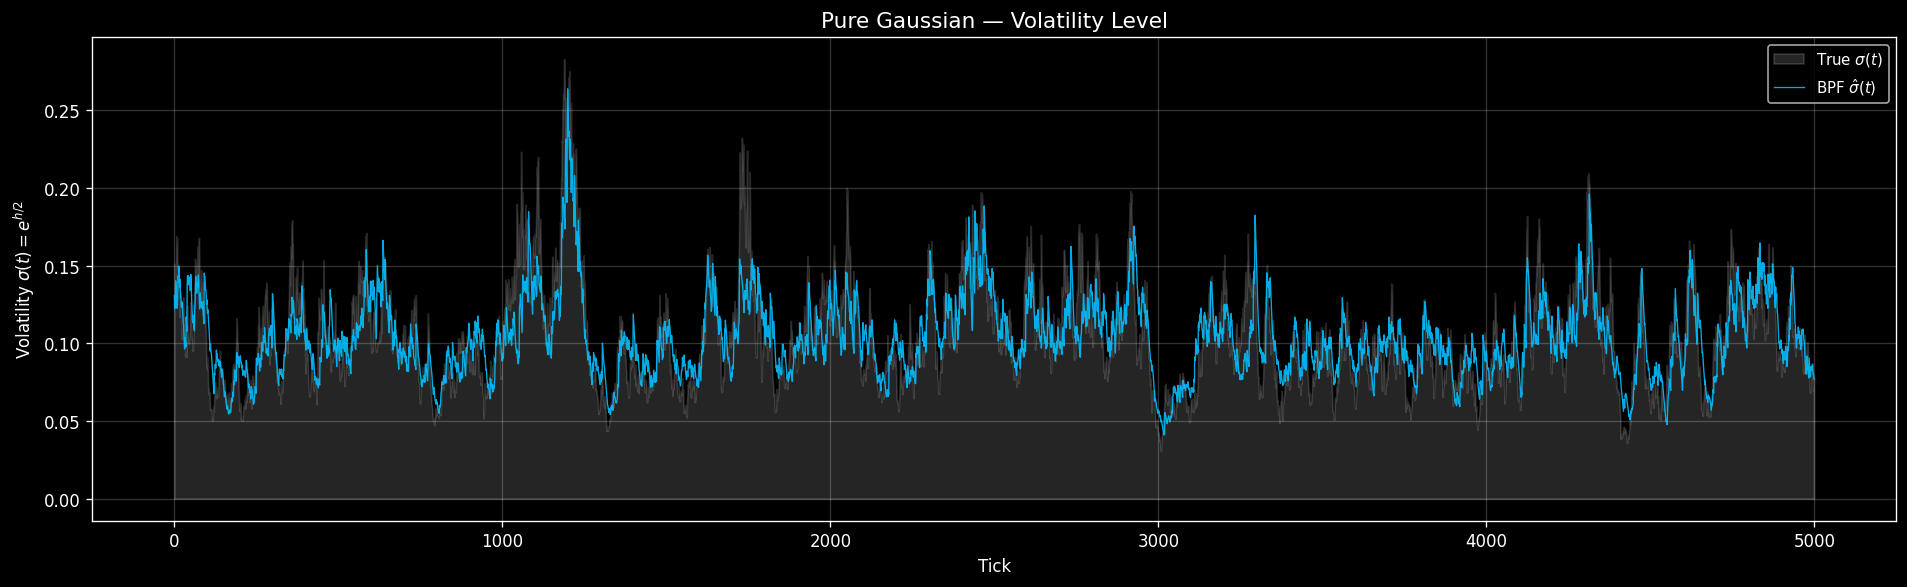

In [5]:
def plot_vol_level(df, scenario_id=1, t_start=0, t_end=None):
    """True vs BPF in volatility space: sigma = exp(h/2)."""
    d = df[df.scenario_id == scenario_id].copy()
    if t_end:
        d = d[(d.tick >= t_start) & (d.tick < t_end)]
    else:
        d = d[d.tick >= t_start]
    
    name = d.scenario_name.iloc[0]
    t = d.tick.values
    
    fig, ax = plt.subplots(figsize=(16, 5))
    ax.fill_between(t, 0, d.true_vol, alpha=0.15, color='white', label=r'True $\sigma(t)$')
    ax.plot(t, np.exp(d.bpf_h / 2), '#00bfff', lw=0.8, alpha=0.9, label=r'BPF $\hat{\sigma}(t)$')
    ax.set_ylabel(r'Volatility $\sigma(t) = e^{h/2}$')
    ax.set_xlabel('Tick')
    ax.set_title(f'{name} — Volatility Level', fontsize=13)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    return fig

for sid in sorted(df.scenario_id.unique()):
    plot_vol_level(df, scenario_id=sid)
    plt.show()

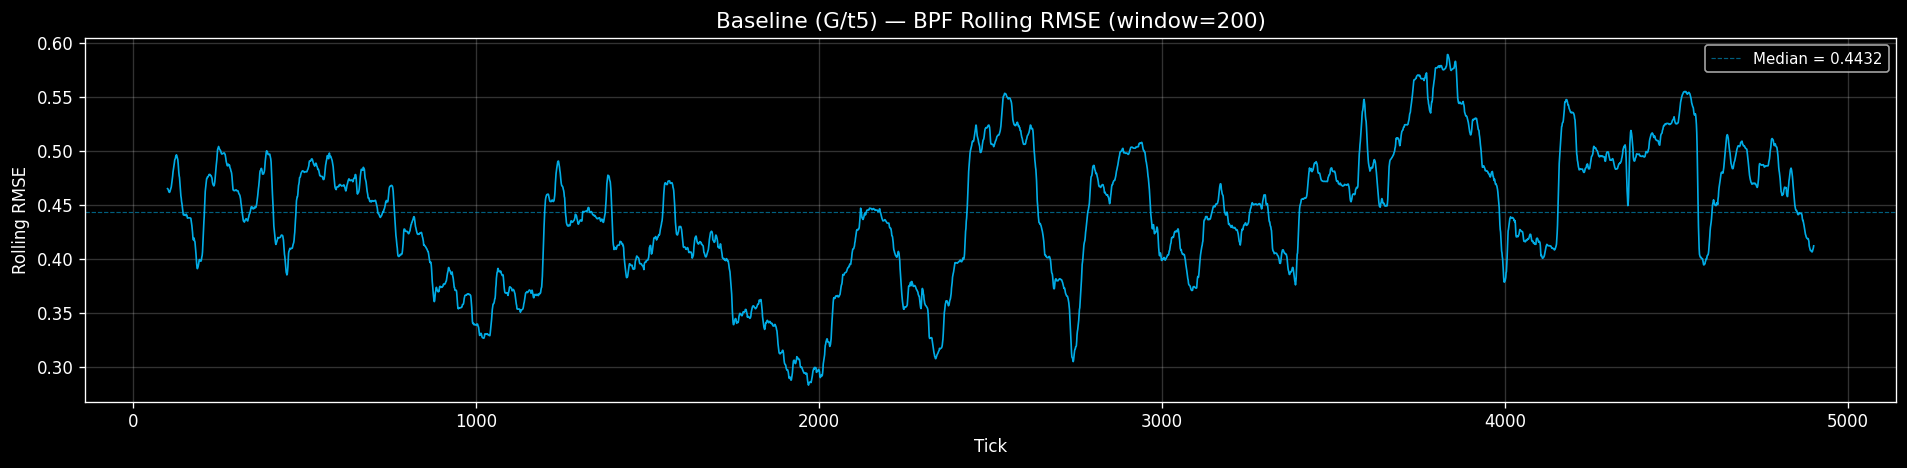

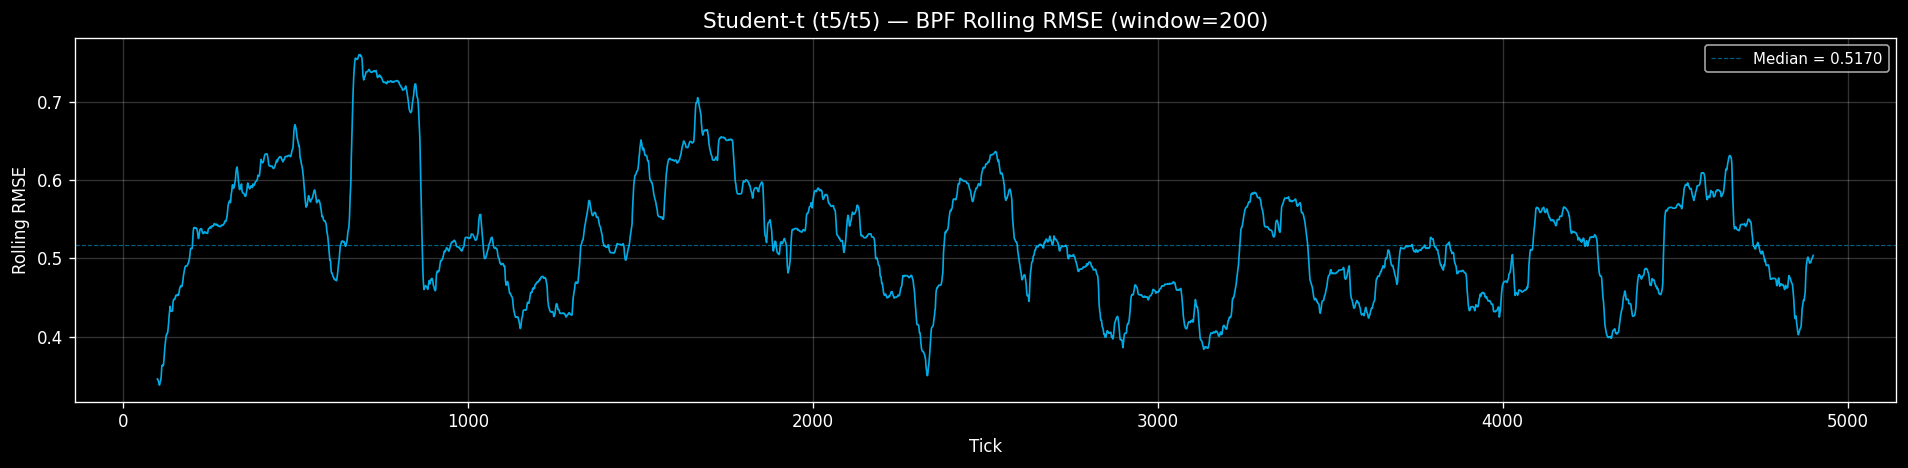

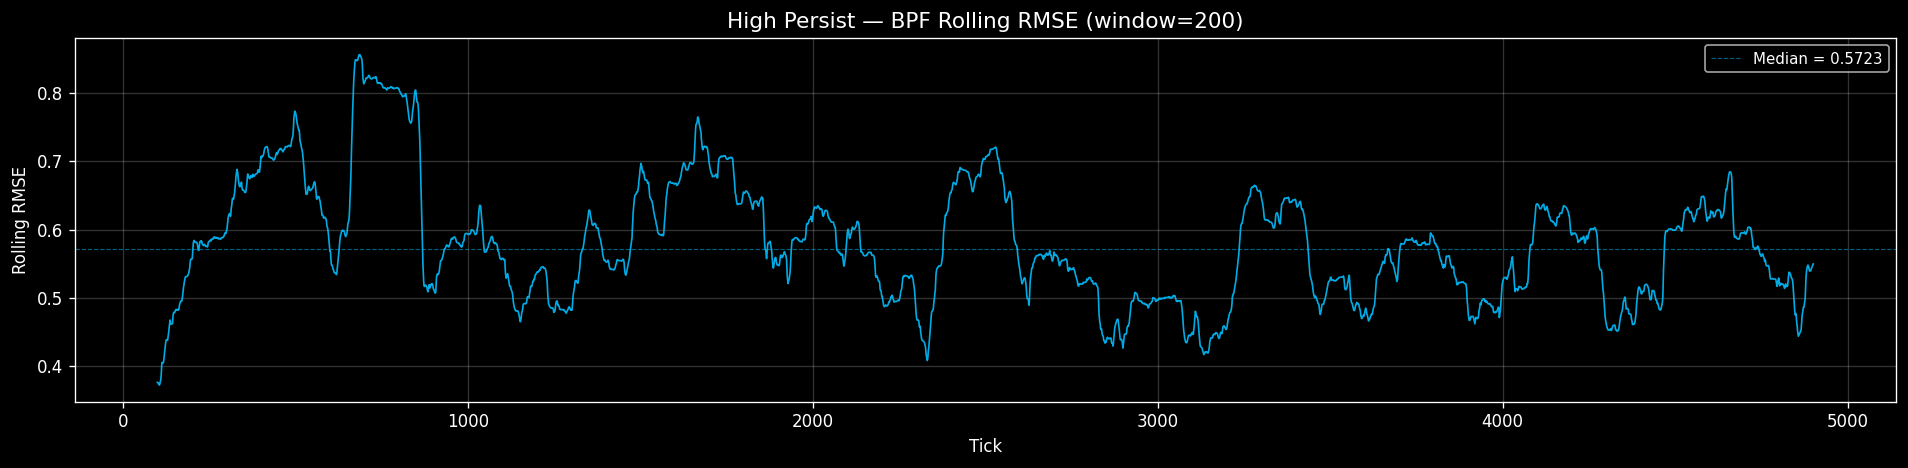

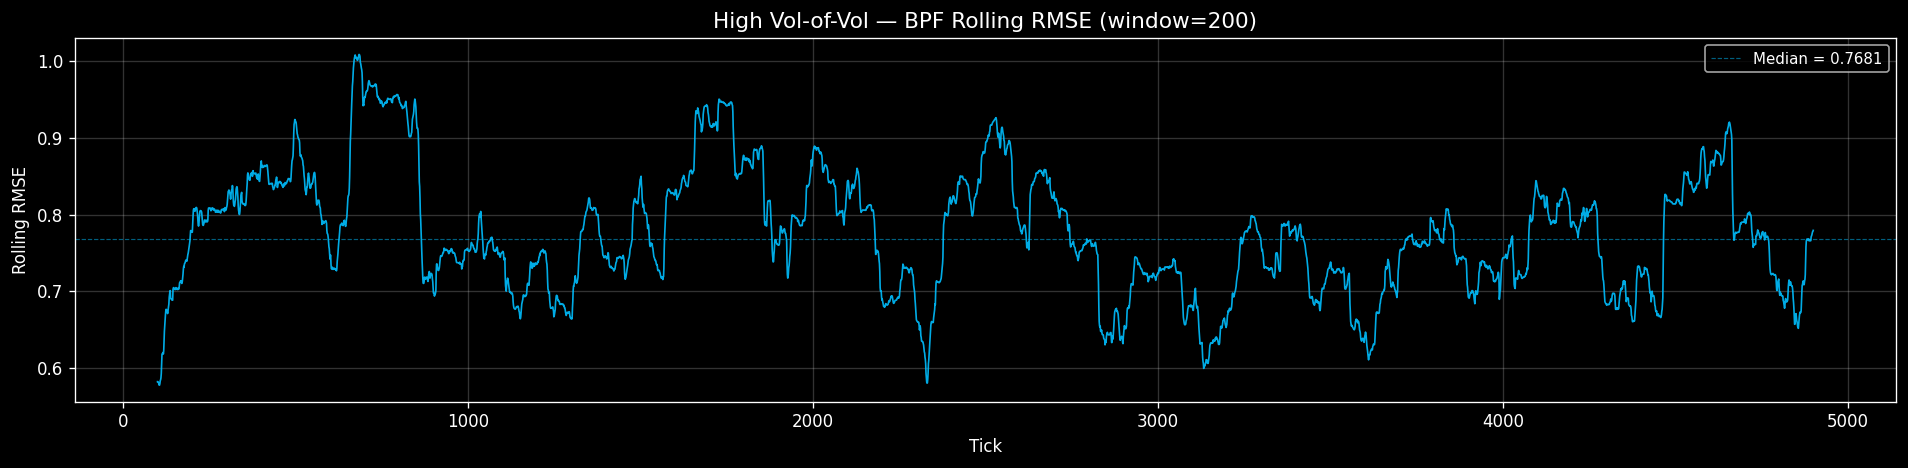

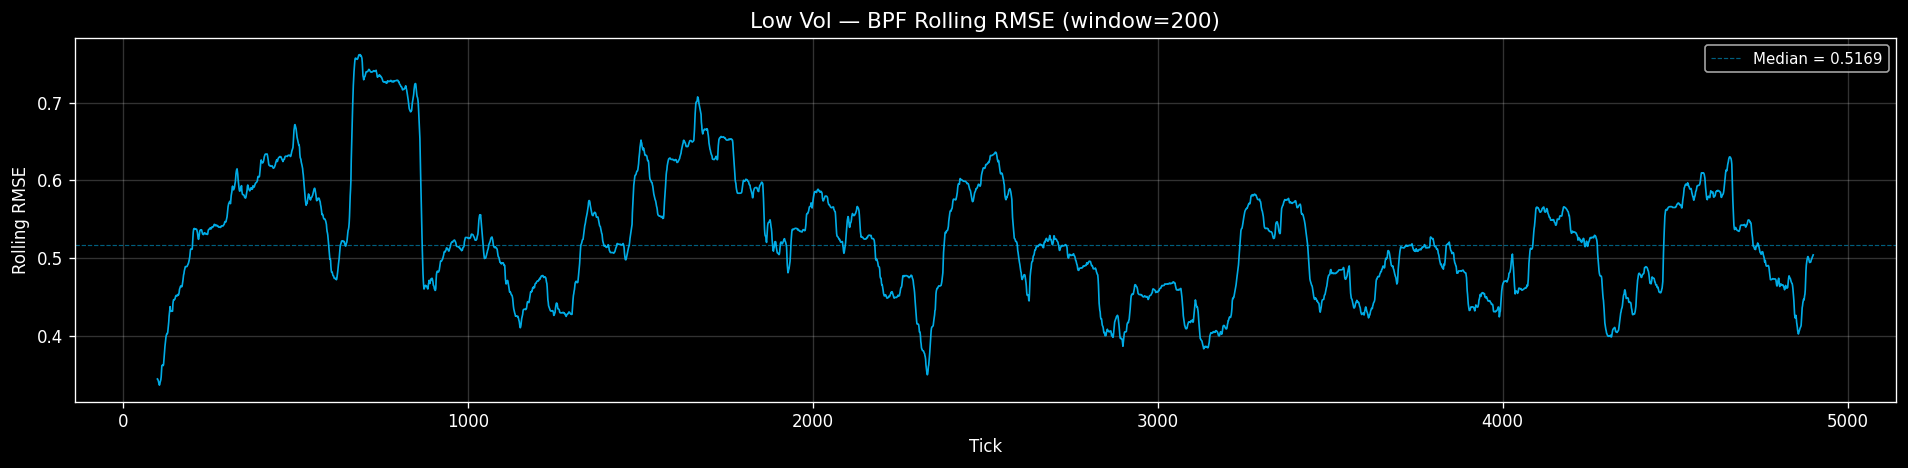

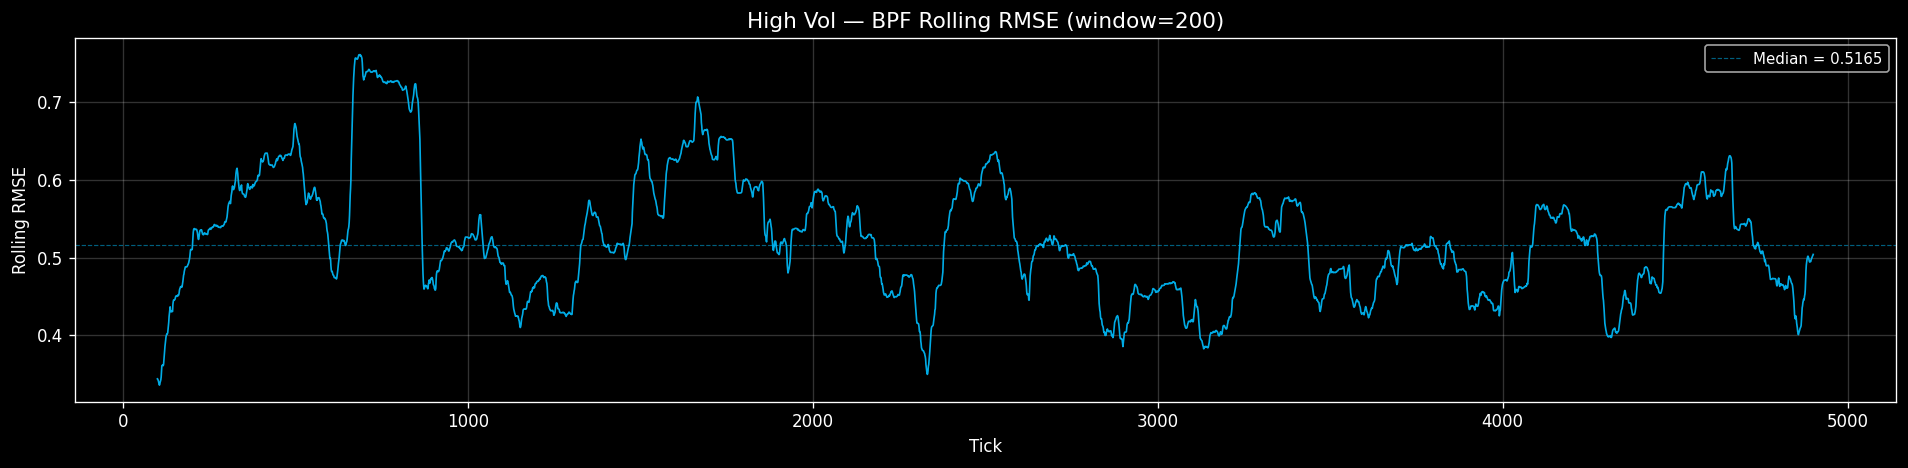

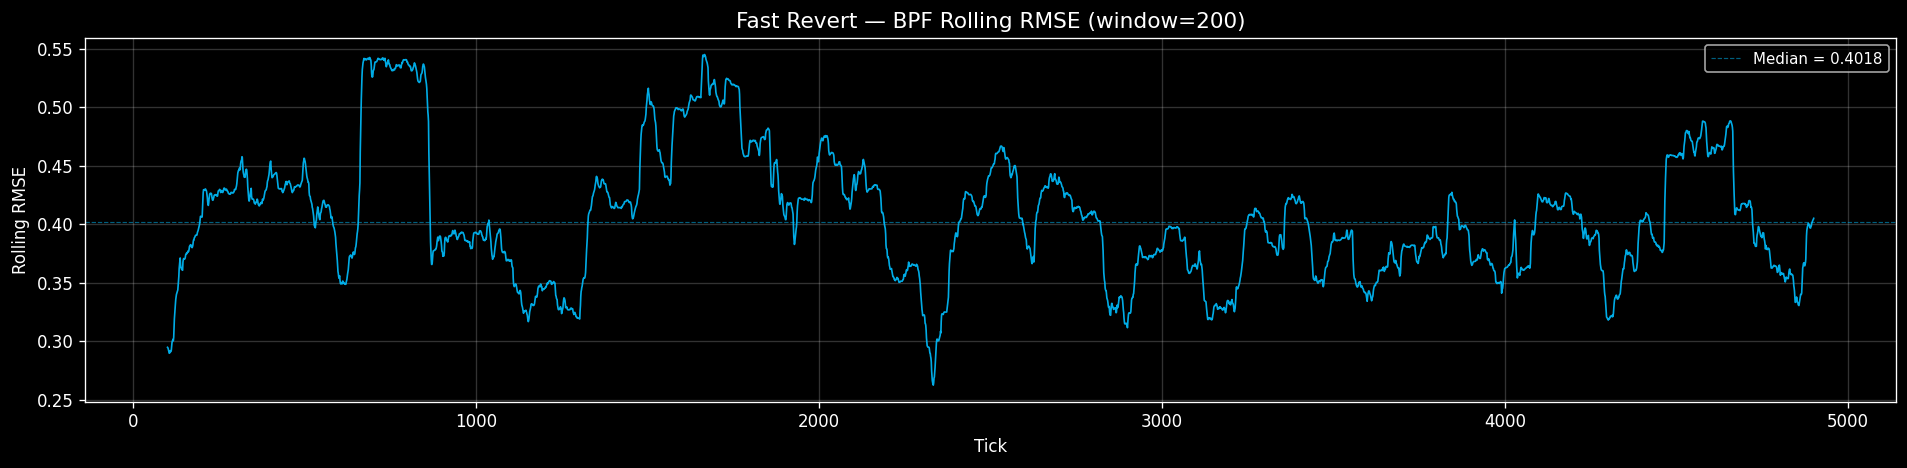

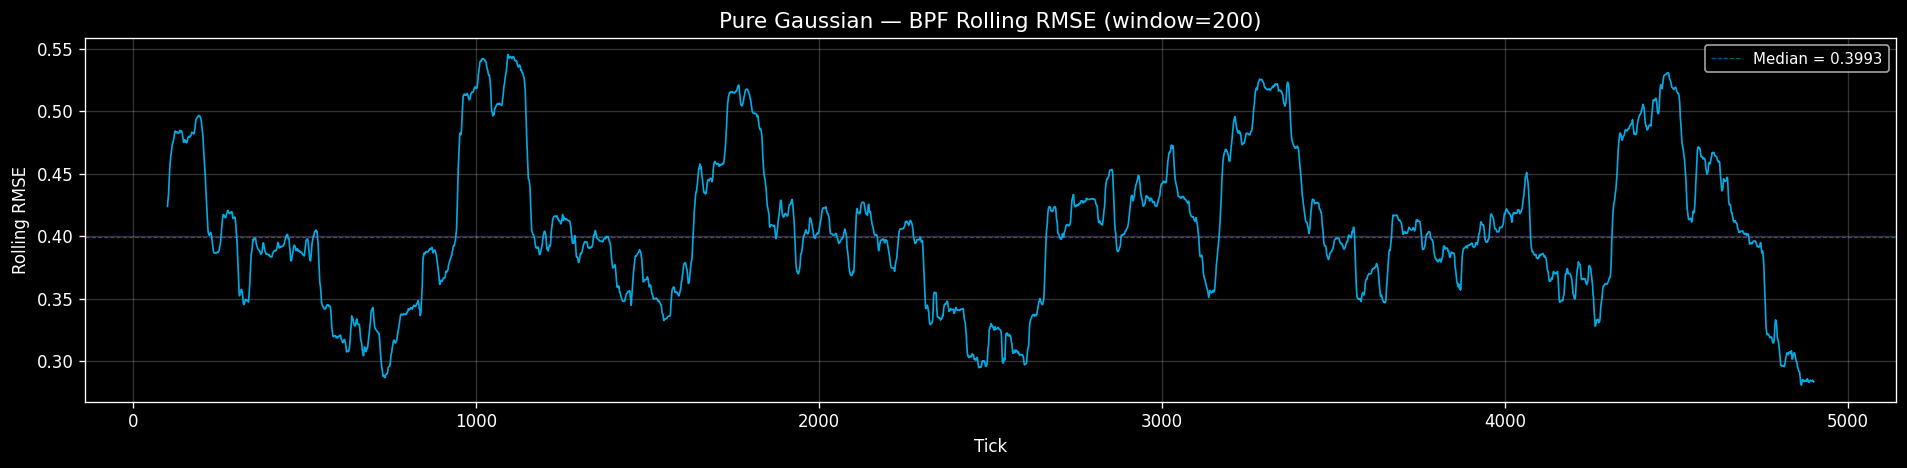

In [6]:
def plot_rolling_rmse(df, scenario_id=1, window=200):
    """Rolling RMSE of BPF over time."""
    d = df[df.scenario_id == scenario_id].copy()
    name = d.scenario_name.iloc[0]
    
    err2 = (d.bpf_h - d.true_h)**2
    rmse = np.sqrt(err2.rolling(window, center=True).mean())
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(d.tick.values, rmse, '#00bfff', lw=1, alpha=0.9)
    ax.axhline(rmse.median(), color='#00bfff', ls='--', lw=0.7, alpha=0.5,
               label=f'Median = {rmse.median():.4f}')
    ax.set_title(f'{name} — BPF Rolling RMSE (window={window})', fontsize=13)
    ax.set_xlabel('Tick')
    ax.set_ylabel('Rolling RMSE')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    return fig

for sid in sorted(df.scenario_id.unique()):
    plot_rolling_rmse(df, scenario_id=sid)
    plt.show()

In [7]:
# RMSE summary table
rows = []
for sid, g in df[df.tick >= 100].groupby('scenario_id'):
    name = g.scenario_name.iloc[0]
    err = g.bpf_h.values - g.true_h.values
    rows.append({
        'Scenario': name,
        'RMSE': np.sqrt(np.mean(err**2)),
        'MAE': np.mean(np.abs(err)),
        'Bias': np.mean(err),
        'Max|Err|': np.max(np.abs(err)),
    })
pd.DataFrame(rows).set_index('Scenario').style.format('{:.4f}')